Grados óptimos: [4 5 5 4 5]
Error máximo minimax (escalado): 3.4229726797452287e-06

Error máximo en escala original: 1.7353967008304494e-05


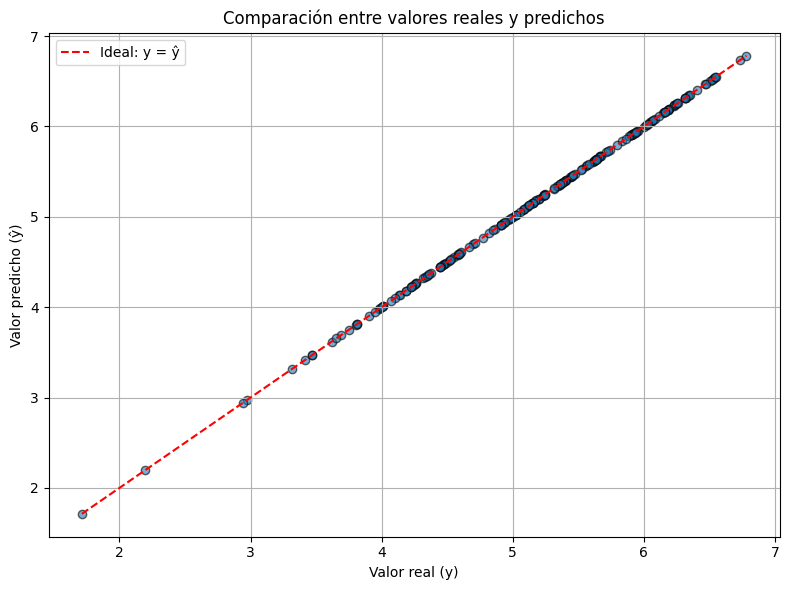


📌 Ecuación simbólica del modelo (valores originales):

687575.935935551*x0**4*x1 + 56090.2654917139*x0**4*x2 - 93578.1163911164*x0**4*x3 + 725430.113350466*x0**4*x4 + 788665.54146709*x0**4 - 858401.710278682*x0**3*x1**2 + 657072.557412192*x0**3*x1*x2 + 57419.1845802717*x0**3*x1*x3 + 1566848.80592066*x0**3*x1*x4 + 6294007.17429705*x0**3*x1 - 176721.001920822*x0**3*x2**2 + 39069.3207913283*x0**3*x2*x3 - 882642.87146828*x0**3*x2*x4 - 603110.440557679*x0**3*x2 - 14646.6730954841*x0**3*x3**2 + 46751.7839826893*x0**3*x3*x4 - 1287767.99255652*x0**3*x3 + 602987.087059408*x0**3*x4**2 + 4655789.54439264*x0**3*x4 + 4139972.07369187*x0**3 + 1103059.80690738*x0**2*x1**3 + 1480046.11332896*x0**2*x1**2*x2 + 2955065.71110197*x0**2*x1**2*x3 - 185263.592952362*x0**2*x1**2*x4 - 910069.131219787*x0**2*x1**2 - 676034.489236441*x0**2*x1*x2**2 + 171919.353263731*x0**2*x1*x2*x3 - 1588807.01564417*x0**2*x1*x2*x4 + 3835619.56561378*x0**2*x1*x2 - 167003.611385003*x0**2*x1*x3**2 - 146522.60740811*x0**2*x1*x3*x4 

In [1]:
import numpy as np
import pandas as pd
import random
import re
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sympy import symbols, simplify
import matplotlib.pyplot as plt

# === Paso 1: Cargar y escalar datos entre 0 y 1 ===
def cargar_datos():
    path = '/Users/Leon/Documents/Data GH/Bolsa con ia/Examen 3/01_Datos Iniciales.txt'
    df = pd.read_csv(path, sep='\t', header=None)

    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values.reshape(-1, 1)

    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y).flatten()

    return X_scaled, y_scaled, scaler_X, scaler_y

# === Paso 2: Obtener potencias de cada término ===
def obtener_potencias(nombre):
    potencias = [0] * 5
    for term in nombre.split():
        match = re.match(r'x(\d+)(\^(\d+))?', term)
        if match:
            idx = int(match.group(1))
            exp = int(match.group(3)) if match.group(3) else 1
            potencias[idx] = exp
    return potencias

# === Paso 3: Evaluar un individuo (vector de grados) ===
def evaluar_modelo(grados, X, y):
    grado_total = max(grados)
    poly = PolynomialFeatures(degree=grado_total, include_bias=False)
    X_poly = poly.fit_transform(X)
    nombres = poly.get_feature_names_out()

    columnas_validas = []
    for i, nombre in enumerate(nombres):
        potencias = obtener_potencias(nombre)
        if all(p <= g for p, g in zip(potencias, grados)):
            columnas_validas.append(i)

    X_reducido = X_poly[:, columnas_validas]
    coef, *_ = np.linalg.lstsq(X_reducido, y, rcond=None)
    y_pred = X_reducido @ coef
    error_max = np.max(np.abs(y - y_pred))
    return error_max, coef, columnas_validas, poly

# === Paso 4: Algoritmo genético ===
def algoritmo_genetico(X, y, generaciones=30, poblacion_size=20, grados_max=5):
    poblacion = [np.random.randint(0, grados_max + 1, size=5) for _ in range(poblacion_size)]

    for gen in range(generaciones):
        aptitudes = [evaluar_modelo(ind, X, y)[0] for ind in poblacion]
        seleccionados = [poblacion[i] for i in np.argsort(aptitudes)[:poblacion_size // 2]]
        nueva_poblacion = seleccionados[:]

        while len(nueva_poblacion) < poblacion_size:
            padre1, padre2 = random.sample(seleccionados, 2)
            punto = random.randint(1, 4)
            hijo = np.concatenate([padre1[:punto], padre2[punto:]])
            if random.random() < 0.1:
                idx = random.randint(0, 4)
                hijo[idx] = random.randint(0, grados_max)
            nueva_poblacion.append(hijo)

        poblacion = nueva_poblacion

    mejor = min(poblacion, key=lambda ind: evaluar_modelo(ind, X, y)[0])
    return mejor, evaluar_modelo(mejor, X, y)

# === Paso 5: Ejecutar todo ===
X, y, scaler_X, scaler_y = cargar_datos()
grados_optimos, (error_minimax, coef, columnas_validas, poly) = algoritmo_genetico(X, y)

print("Grados óptimos:", grados_optimos)
print("Error máximo minimax (escalado):", error_minimax)

# === Paso 6: Predicción y reescalado ===
X_poly = poly.fit_transform(X)
X_reducido = X_poly[:, columnas_validas]
y_pred = X_reducido @ coef

y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_real_original = scaler_y.inverse_transform(y.reshape(-1, 1)).flatten()
error_max_real = np.max(np.abs(y_real_original - y_pred_original))

print("\nError máximo en escala original:", error_max_real)

# === Paso 7: Visualización ===
plt.figure(figsize=(8, 6))
plt.scatter(y_real_original, y_pred_original, alpha=0.6, edgecolors='k')
plt.plot([min(y_real_original), max(y_real_original)],
         [min(y_real_original), max(y_real_original)],
         'r--', label='Ideal: y = ŷ')
plt.xlabel('Valor real (y)')
plt.ylabel('Valor predicho (ŷ)')
plt.title('Comparación entre valores reales y predichos')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Paso 8: Ecuación simbólica en valores originales ===
x_orig = symbols('x0 x1 x2 x3 x4')
mins = scaler_X.data_min_
maxs = scaler_X.data_max_
nombres = poly.get_feature_names_out()
ecuacion_real = 0

for i, c in zip(columnas_validas, coef):
    termino = 1
    nombre = nombres[i]
    for var in nombre.split():
        if '^' in var:
            var_idx, pot = var[1:].split('^')
            var_idx = int(var_idx)
            base = (x_orig[var_idx] - mins[var_idx]) / (maxs[var_idx] - mins[var_idx])
            termino *= base**int(pot)
        else:
            var_idx = int(var[1:])
            base = (x_orig[var_idx] - mins[var_idx]) / (maxs[var_idx] - mins[var_idx])
            termino *= base
    ecuacion_real += c * termino

print("\n📌 Ecuación simbólica del modelo (valores originales):\n")
print(simplify(ecuacion_real))




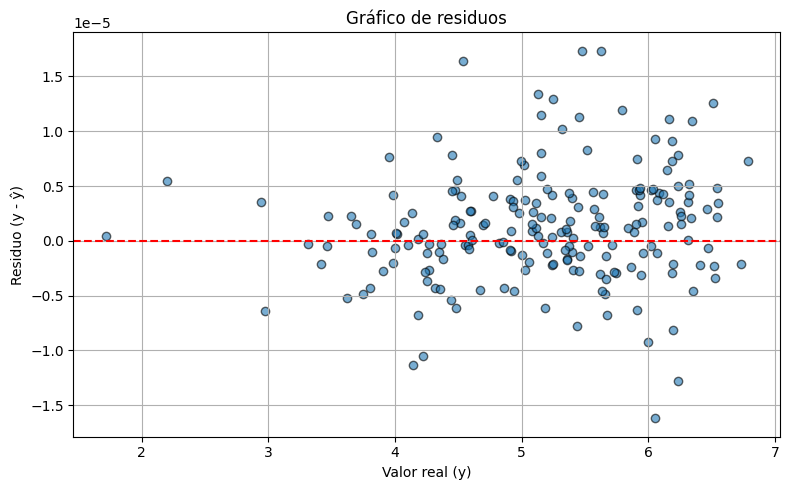

In [2]:
# === Gráfico de residuos ===
residuos = y_real_original - y_pred_original

plt.figure(figsize=(8, 5))
plt.scatter(y_real_original, residuos, alpha=0.6, edgecolors='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Valor real (y)')
plt.ylabel('Residuo (y - ŷ)')
plt.title('Gráfico de residuos')
plt.grid(True)
plt.tight_layout()
plt.show()


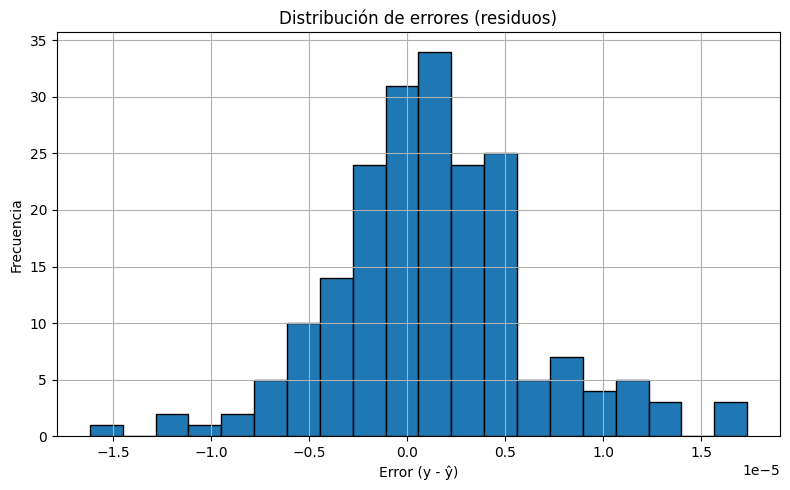

In [3]:
# === Histograma de residuos ===
plt.figure(figsize=(8, 5))
plt.hist(residuos, bins=20, edgecolor='black')
plt.title('Distribución de errores (residuos)')
plt.xlabel('Error (y - ŷ)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.tight_layout()
plt.show()


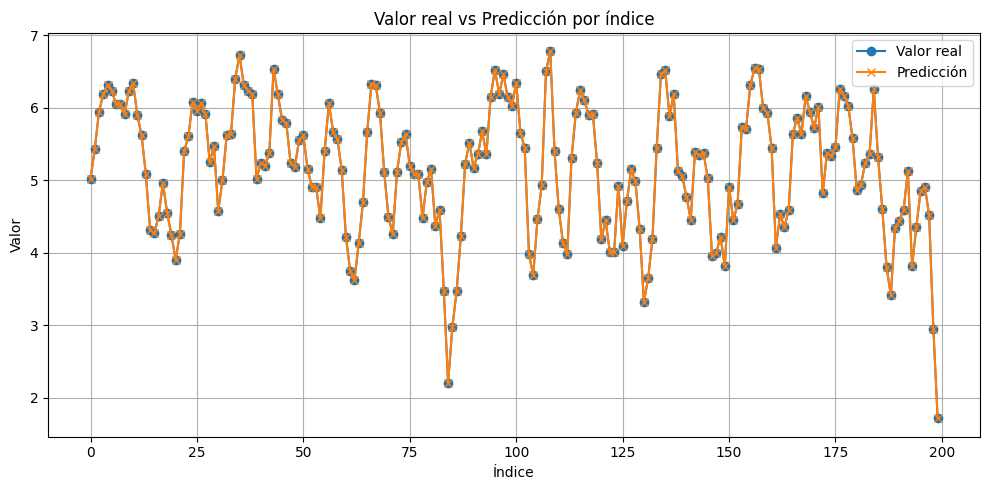

In [4]:
# === Comparación temporal o por índice ===
plt.figure(figsize=(10, 5))
plt.plot(y_real_original, label='Valor real', marker='o')
plt.plot(y_pred_original, label='Predicción', marker='x')
plt.title('Valor real vs Predicción por índice')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


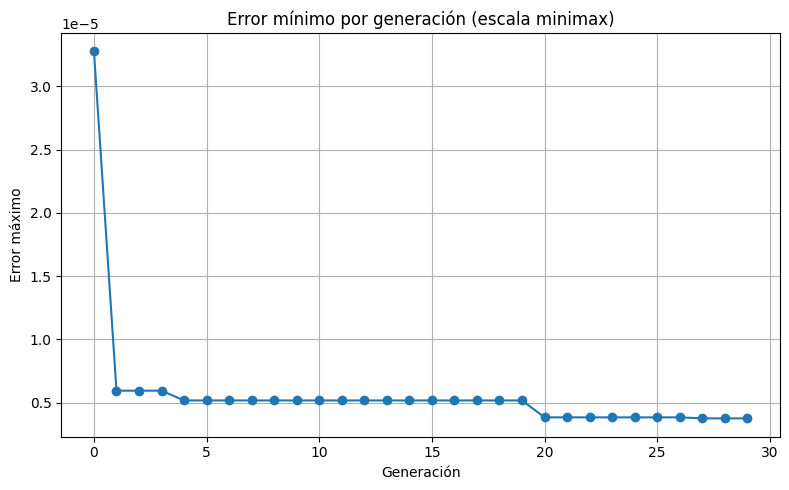

In [5]:
# === Algoritmo genético con tracking del error por generación ===
def algoritmo_genetico_con_tracking(X, y, generaciones=30, poblacion_size=20, grados_max=5):
    poblacion = [np.random.randint(0, grados_max + 1, size=5) for _ in range(poblacion_size)]
    mejores_por_gen = []

    for gen in range(generaciones):
        aptitudes = [evaluar_modelo(ind, X, y)[0] for ind in poblacion]
        mejores_por_gen.append(np.min(aptitudes))
        seleccionados = [poblacion[i] for i in np.argsort(aptitudes)[:poblacion_size // 2]]
        nueva_poblacion = seleccionados[:]

        while len(nueva_poblacion) < poblacion_size:
            padre1, padre2 = random.sample(seleccionados, 2)
            punto = random.randint(1, 4)
            hijo = np.concatenate([padre1[:punto], padre2[punto:]])
            if random.random() < 0.1:
                idx = random.randint(0, 4)
                hijo[idx] = random.randint(0, grados_max)
            nueva_poblacion.append(hijo)

        poblacion = nueva_poblacion

    mejor = min(poblacion, key=lambda ind: evaluar_modelo(ind, X, y)[0])
    return mejor, evaluar_modelo(mejor, X, y), mejores_por_gen

# --- Reentrenar modelo con seguimiento ---
X, y, scaler_X, scaler_y = cargar_datos()
grados_optimos, (error_minimax, coef, columnas_validas, poly), errores_por_gen = algoritmo_genetico_con_tracking(X, y)

# --- Gráfica del error por generación ---
plt.figure(figsize=(8, 5))
plt.plot(errores_por_gen, marker='o')
plt.title('Error mínimo por generación (escala minimax)')
plt.xlabel('Generación')
plt.ylabel('Error máximo')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# grados_optimos : np.array o lista con los grados del modelo
# error_minimax : valor del error en escala reescalada
# y_real_original, y_pred_original : arrays de valores en escala original

# Calcular métricas
mae = mean_absolute_error(y_real_original, y_pred_original)
mse = mean_squared_error(y_real_original, y_pred_original)
rmse = np.sqrt(mse)
r2 = r2_score(y_real_original, y_pred_original)

# Generar salida en formato LaTeX
print("\\section*{Resultados}")
print("\\begin{itemize}")
print(f"  \\item \\textbf{{Grados óptimos encontrados:}} \\texttt{{{list(grados_optimos)}}}")
print(f"  \\item \\textbf{{Error minimax (reescalado):}} \\num{{{error_minimax:.6f}}}")
print(f"  \\item \\textbf{{Métricas:}}")
print("  \\begin{itemize}")
print(f"    \\item MAE: \\num{{{mae:.6f}}}")
print(f"    \\item MSE: \\num{{{mse:.6f}}}")
print(f"    \\item RMSE: \\num{{{rmse:.6f}}}")
print(f"    \\item R\\textsuperscript{{2}}: \\num{{{r2:.6f}}}")
print("  \\end{itemize}")
print("\\end{itemize}")



\section*{Resultados}
\begin{itemize}
  \item \textbf{Grados óptimos encontrados:} \texttt{[5, 5, 4, 4, 5]}
  \item \textbf{Error minimax (reescalado):} \num{0.000004}
  \item \textbf{Métricas:}
  \begin{itemize}
    \item MAE: \num{0.000004}
    \item MSE: \num{0.000000}
    \item RMSE: \num{0.000005}
    \item R\textsuperscript{2}: \num{1.000000}
  \end{itemize}
\end{itemize}
